# Navigating a Banana World


### 1. Imports

Import the necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import time
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# Custom RL Agent
from dqn_agent import Agent

### 2. Create the Unity Environment

Using the Banana environment, a unity agents 'brain' is created, which is responsible for deciding the agents actions. 

In [2]:
# Set environment and display information
env = UnityEnvironment(file_name="Banana.app")

# Set the default BananaBrain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Train the Agent

#### Training Implementation
A `dqn_training` function is used for implementating the training of the agent and stores the best weights of the model once a score of 13 or more has been achieved.

This algorithm consists of a Q-Learning approach with a standard experience relay and fixed Q-targets.

#### Deep Q-Network Architecture
- An input layer with 37 inputs, representing the state size
- 2 hidden layers, both with 64 hidden nodes that are passed through relu activation functions
- An output layer with 4 outputs, for the number of actions

#### Hyperparameters Used
- `BUFFER_SIZE = int(1e5)`: replay buffer size
- `BATCH_SIZE = 64`: minibatch size
- `GAMMA = 0.99`: discount factor
- `TAU = 1e-3`: used for soft update of target parameters
- `LR = 5e-4`: learning rate 
- `UPDATE_EVERY = 4`: how often to update the network

In [3]:
def dqn_training(brain_name, n_episodes=2000, max_t=1000, eps_start=1.0, 
                 eps_end=0.01, eps_decay=0.995):
    """
    Perform Deep Q-Learning training on the agent.
    
    Params
    ======
    brain_name (string): name of agent brain to use
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float): minimum value of epsilon
    eps_decay (float): multiplicative factor (per episode) for decreasing epsilon 
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    # Iterate over each episode
    for i_episode in range(1, n_episodes+1):
        # Reset environment, set initial state and reward score every episode
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        # Iterate over each timestep
        for t in range(max_t):
            # Perform an action in the environment
            action = agent.act(state, eps).astype(np.int32)
            env_info = env.step(action)[brain_name]
            
            # Set new experience and interact with the environment
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            
            # Update step and score
            state = next_state
            score += reward
            
            # Break loop if episode completed
            if done:
                break 
        
        # Save most recent score
        scores_window.append(score)
        scores.append(score)
        
        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)
        
        # Output episode information
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        
        # Save environment if goal achieved
        if np.mean(scores_window) >= 13.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    # Return reward scores
    return scores

In [4]:
# Initialize the environment
env_info = env.reset(train_mode=True)[brain_name]

# Set number of actions
action_size = brain.vector_action_space_size # 4

# Set the state space and size
state = env_info.vector_observations[0]
state_size = len(state) # 37

# Create the agent
agent = Agent(state_size, action_size, seed=0)
print(agent.qnetwork_local) # View network used
print()

# Train the agent and calculate time taken
start_time = time.time()
scores = dqn_training(brain_name, n_episodes=1000, max_t=1500)
train_time = (time.time() - start_time) / 60
print(f"\nTotal Training Time: {train_time:.2f} mins")

QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=4, bias=True)
)

Episode 100	Average Score: 1.10
Episode 200	Average Score: 4.49
Episode 300	Average Score: 8.38
Episode 400	Average Score: 10.59
Episode 500	Average Score: 12.55
Episode 521	Average Score: 13.03
Environment solved in 421 episodes!	Average Score: 13.03

Total Training Time: 10.99 mins


### 4. Analyse the Training Results

Reviewing the graph we can see the score slowly increase over each episode, where the highest score is the 421st episode. Notice how this isn't a smooth learning process as it is only a basic implementation of a Deep Q-Network (DQN).

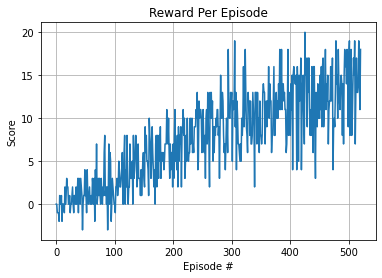

In [5]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.title('Reward Per Episode')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid(True)
plt.show()

### 5. Test the Trained Agent
Now that the agent has been trained, the environment can be reset and set it to testing mode using the `train_mode=False` flag, load the best weights for the agent and run it in the Unity environment.

In [6]:
# Initialize environment and score
env_info = env.reset(train_mode=False)[brain_name]
score = 0

# Set the state space
state = env_info.vector_observations[0]
state_size = len(state)

# Set number of actions
action_size = brain.vector_action_space_size # 4

# Create the agent and load its best weights
agent = Agent(state_size, action_size, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# Test the agents progress
while True:
    # Perform an action in the environment
    action = agent.act(state).astype(np.int32)
    env_info = env.step(action)[brain_name]

    # Set new experience and interact with the environment
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    agent.step(state, action, reward, next_state, done)

    # Update step and score
    state = next_state
    score += reward

    # Exit loop when finished
    if done:
        break
    
# Return score for test run
print(f"Score: {score:.2f}")

Score: 6.00


### 6. Close the Environment
When finished, we close the environment.

In [7]:
env.close()

### 7. Test Results Analysis
Using a basic DQN, the agent is able to solve the environment within ~400 episodes.

Notice how the test of the agent may become erratic in its behaviour once it has deviated from its trained path, this is common with a basic DQN and can be mitigated by further training or by using extensions, such as:
- Double DQN
- Prioritized Experience Replay
- Dueling DQN

Alternatively, another implementation to solve the environment can consist of a combination of both convolutional layers and fully-connected layers, over the basic approach of strictly fully-connected layers.